Centro de Estudos e Sistemas Avançados do Recife

Pós-graduação em Engenharia e Análise de Dados

Disciplina de RNA e Deep Learning

Professor: Vitor Casadei

Aluno: Anísio Pereira Batista Filho

# PyTorch: Variable, Gradientes e Grafo Computacional

## Objetivos

Este notebook introduz
- o conceito de `Variables` do PyTorch,
- uma interpretação numérica intuitiva do gradiente, e o
- grafo computacional, utilizado para o cálculo automático do gradiente de uma função.

Um dos principais fundamentos para que o PyTorch seja adequado para deep learning é a sua habilidade de
calcular o gradiente automaticamente a partir da expressões definidas. Essa facilidade é implementada
pelo tipo Variable do PyTorch, que adiciona ao tensor a facilidade de cálculo automático do gradiente pela construção dinâmica do grafo computacional.

## Grafo computacional

```
    y_pred = x * w
    e = y_pred - y
    e2 = e**2
    J = e2.sum()
```

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/GrafoComputacional.png)

Variable possui 3 campos: o dado em si (data), o gradiente (grad) e um apontador (creator) para construir o grafo da backpropagation. Uma expressão utilizada para o cálculo do gradiente exige que todas suas expressões sejam calculadas com Variables, caso contrário não é possível construir o grafo computacional.

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/variables.png)

In [1]:
import torch
from torch.autograd import Variable

## Variable é criada a partir de um tensor e possui as mesmas funcionalidades

In [2]:
y_t = 2 * torch.arange(0.,4.)
y = Variable(y_t); y

tensor([0., 2., 4., 6.])

In [3]:
x = Variable(torch.arange(0.,4.)); x

tensor([0., 1., 2., 3.])

In [4]:
w = Variable(torch.ones(1),requires_grad=True); w

tensor([1.], requires_grad=True)

## Cálculo automático do gradiente da função perda J

Seja a expressão: $$ J = ((x  w) - y)^2 $$

Queremos calcular a derivada de $J$ em relação a $w$.

### Montagem do grafo computacional

In [5]:
# predict (forward)
y_pred = x * w

# cálculo da perda J: loss
e = y_pred - y
e2 = e.pow(2)
J = e2.sum()
J

tensor(14., grad_fn=<SumBackward0>)

## Auto grad - processa o grafo computacional backwards

O `backward()` varre o grafo computacional a partir da variável a ele associada e calcula o gradiente para todas as `Variables` que possuem o atributo `requires_grad` como verdadeiro.
O `backward()` destroi o grafo após sua execução. Isso é intrínsico ao PyTorch pelo fato dele ser uma rede dinâmica.

In [6]:
J.backward()
print(w.grad)

tensor([-28.])


In [7]:
w.grad.data.zero_();

## Interpretação do Gradiente

O gradiente de uma variável final (J) com respeito à outra variável de entrada (w) pode ser interpretado como o quanto a variável final J vai aumentar se houver um pequeno aumento na variável de entrada (w).
Por exemplo suponha que o gradiente seja 28. Isto significa se aumentarmos a variável w de 0.001, então J vai aumentar de 0.028.

In [8]:
eps = 0.001
y_pred = x * (w+eps)
J_new = (y_pred - y).pow(2).sum()
J_new

tensor(13.9720, grad_fn=<SumBackward0>)

In [9]:
print((J_new - J).data.numpy())

-0.027988434


## Back propagation

Uma forma equivalente explícita de calcular o gradiente é fazendo o processamento do backpropagation no grafo computacional, de forma explícita.
Apenas como ilustração.

Função de perda:
$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$

Gradiente:
$$  \mathbf{\nabla{J_w}} = \frac{2}{M}\mathbf{x^T}(\mathbf{x w^T} - \mathbf{y}) $$

Atualização dos parâmetros pelo gradiente descendente:
$$ \mathbf{w} = \mathbf{w} − \eta (\mathbf{\nabla J_w})^T $$

In [10]:
import numpy as np

dJ = 1.
de2 = dJ * np.ones((4,))
de = de2 * 2 * e.data.numpy()
dy_pred = de
dw = (dy_pred * x.data.numpy()).sum()
print(dJ)
print(de2)
print(de)
print(dw)


1.0
[1. 1. 1. 1.]
[ 0. -2. -4. -6.]
-28.0


## Visualizando o grafo computacional

In [11]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to c:\users\anisi\appdata\local\temp\pip-req-build-wkn01tkg
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz 'C:\Users\anisi\AppData\Local\Temp\pip-req-build-wkn01tkg'


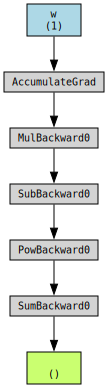

In [12]:
from torchviz import make_dot, make_dot_from_trace
J = ((w * x) - y).pow(2).sum()
p = {'w':w} # dicionário de parâmetros
out = make_dot(J,params=p)
out


# Exercícios

## Questões

1. Por que numa expressão computacional não é possível misturar `Variable` com tensores?

Em PyTorch, `Variable` e `Tensor` são duas classes diferentes, embora muito semelhantes. A classe `Variable` foi projetada para conter tanto um tensor quanto seu gradiente, além de um link para a função que criou a variável (para permitir a retropropagação). No entanto, a partir do PyTorch 0.4.0, a classe `Variable` foi depreciada, e agora é recomendado usar apenas `Tensor`. Isso ocorre porque a funcionalidade da `Variable` foi incorporada à classe `Tensor`. Portanto, em versões mais recentes do PyTorch, você pode realizar operações diretamente em tensores e calcular gradientes. Se você tentar misturar `Variable` e `Tensor` em uma expressão, pode encontrar problemas de compatibilidade.

2. O que acontece com o grafo computacional após execução do `backward()`?

Quando você chama `backward()`, o PyTorch calcula automaticamente os gradientes e os armazena nas variáveis do grafo computacional. Isso significa que para cada variável `x` no grafo que tem `x.requires_grad=True`, `x.grad` armazenará o gradiente de `x` com relação a alguma variável escalar (geralmente a perda que você está tentando minimizar durante o treinamento). Após a chamada para `backward()`, os gradientes são armazenados e podem ser acessados usando a propriedade `.grad` das variáveis. No entanto, note que o grafo computacional em si é destruído durante a operação `backward()` para liberar memória, o que significa que você não pode chamar `backward()` novamente a menos que reexecute o forward pass.

## Atividades

1. Execute um passo de atualização do valor de w, pelo
gradiente descendente. Utilize um fator de aprendizado (*learning rate*) de 0.1
para atualizar o `w`. Após, recalcule a função de perda:

    - w = w - lr * w.grad.data
    - execute a célula 1.3.1 e verifique o quanto que a perda J diminuiu
    
2. No trecho abaixo, uma rede bastante conhecida, `resnet18` contendo 18 camadas
   é criada, tendo
   como entrada `xin` que é convertida para `Variable`, resultando na saída `y`.
   
   Descomente a linha que cria a vizualização do grafo computacional e execute a
   célula para visualizar o grafo computacional da rede `resnet18`:

Atividade 1:
  * Como no exemplo desenvolvido em sala w = 1 e w.grad.data = -28. Para o caso do learing rate 0.01 tem-se:
    * w_novo = 1 - 0.01 * (-28) = 1 + 0.28 = 1.28
    * y_hat = [0 1 2 3] * 1.28 = [0 1.28 2.56 3.84]
    * y_hat - y = [0 1.28 2.56 3.84] - [0 2 4 6] = [0 -0.72 -1.44 -2.16]
    * J = soma((y_hat - y)^2) = soma([0 0.52 2.07 4.66]) = 7.26
  * De fato, com um learning rate menor, o modelo foi menos errático, o que pode levar a uma convergência ao mínimo melhor.

In [ ]:
#Solução Atividade 1

# Atividade 1:
# execute a célula 1.3.1 e verifique o quanto que a perda J diminuiu

w_novo = 1.28

# predict (forward)
y_hat = x * w_novo

# cálculo da perda J: loss
e_novo = y_hat - y
e2_novo = e_novo.pow(2)
J_novo = e2_novo.sum()
print(f'Ao utilizar o peso com o learning rate (lr) de 0.01 obtêm-se um erro menor {J_novo:.2f}, ao invés de {J:.2f} obtido com lr = 0.1 do exemplo inicial.')

In [13]:
## INCOMPLETO
# Definindo a taxa de aprendizado
lr = 0.1

# Atualizando w usando gradiente descendente
w = w - lr * w.grad.data

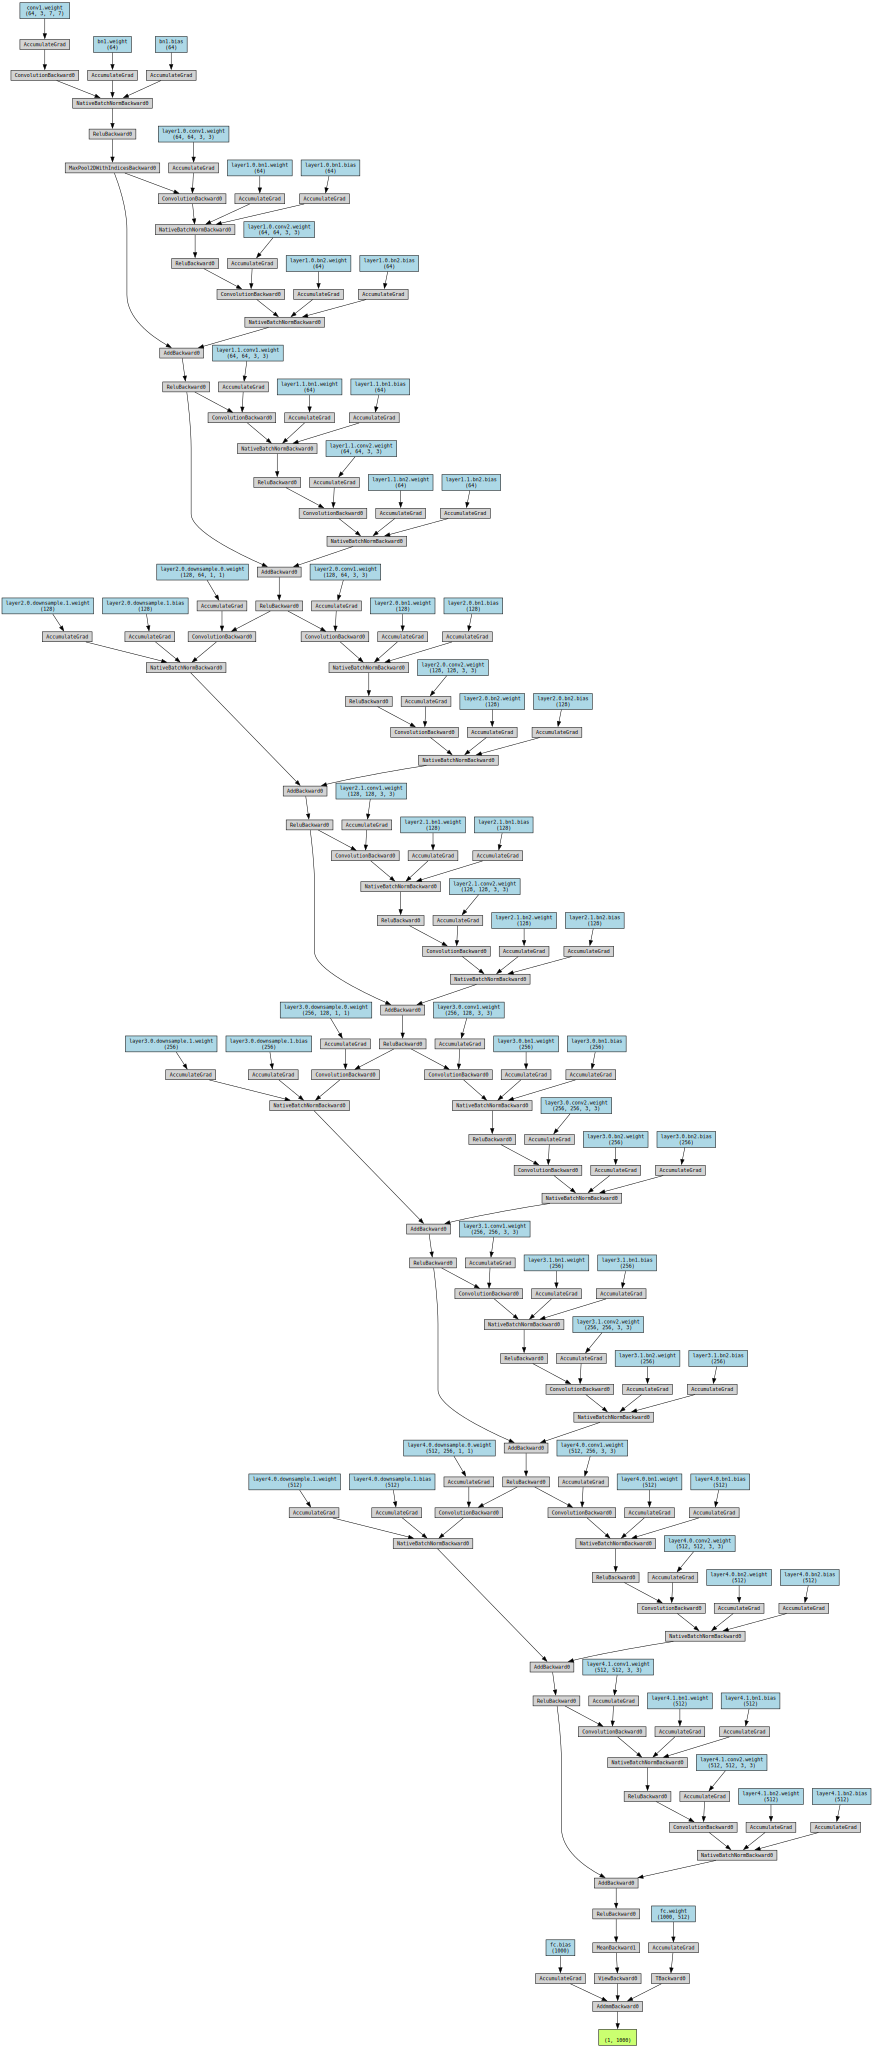

In [16]:
!pip install torchviz
from torchviz import make_dot
from torchvision import models

# Criação da rede resnet18 e obtenção da saída y
xin = torch.randn(1,3,224,224)
resnet18 = models.resnet18()
y = resnet18(xin)

# Criação do grafo computacional
g = make_dot(y, params=dict(resnet18.named_parameters()))

# Visualização do grafo
g

# Aprendizados com este notebook

Neste notebook aprendi por que numa expressão computacional não é possível misturar `Variable` com tensores e também o que acontece com o grafo computacional após execução do `backward()`